In [108]:
!pip install pennylane-lightning

### Importing libraries

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane.templates import QFT
import matplotlib.image as mpimg
from itertools import product
from tqdm import tqdm
from collections import Counter
from PIL import Image

In [110]:
def rgb2gray(rgb):
    """ Convert an RGB digital image to greyscale. """
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [111]:
def vectorization(img, Cr, Cc, renorm=False):
    "Vectorize the image into amplitude-encoding patches suitable for quantum circuits"
    # split the original image (Mr, Mc) into S equal-size patches of shape (Cr, Cc)
    Mr, Mc = img.shape
    patches = (img.reshape(Mc//Cr, Cr, -1, Cc).swapaxes(1, 2).reshape(-1, Cr, Cc))
    # 64 patches, (64, 64, 64) shape; S=64

    # vectorize each patch and collect all in a (N, Cr*Cc) array
    vect_patches = np.reshape(patches,  (patches.shape[0], Cr*Cc)) # (64, 4096)

    # normalize each (Cr*Cc) vector to the intensity of the corresponding (Cr, Cc) patch
    states = np.zeros((patches.shape[0], Cr*Cc)) # (64, 4096)
    norm = np.zeros(patches.shape[0])

    for idx in range(patches.shape[0]): # for each patch
        # compute the sum of pixels intensities
        norm[idx] = vect_patches[idx].sum()
        if norm[idx] == 0:
            raise ValueError('Pixel value is 0')
        # normalize the patch vector so that its entries sum is 1
        tmp = vect_patches[idx] / norm[idx]
        # take the element-wise square root of the normalized vector
        states[idx] = np.sqrt(tmp)
    if renorm == False:
        norm = np.ones(patches.shape[0])
    print(states[:10])

    return states, norm # amplitudes, pixek intensities' sums

In [112]:
def qft_swaps(wires):
    n = len(wires)
    # apply QFT to all qubits
    qml.QFT(wires=wires)
    # add swaps to reverse qubit order!
    for i in range(n // 2):
        qml.SWAP(wires=[wires[i], wires[n - i - 1]])


def iqft_swaps(wires):
    n = len(wires)
    # swaps again - BEFORE iqft
    for i in reversed(range(n // 2)):
        qml.SWAP(wires=[wires[i], wires[n-i-1]])
    qml.adjoint(QFT)(wires=wires)

In [113]:
def circuit_builder(states, n0, n2, shots):
    ntilde = (n0 - n2) // 2
    n1 = n0 - ntilde

    qnodes = []

    # define device with n0 qubits
    dev = qml.device("lightning.qubit", wires=n0, shots=shots)

    for idx in range(states.shape[0]):
        # qnode to capture current input state
        @qml.qnode(dev)
        def circuit():
            print("State norm:", np.linalg.norm(states[idx]))
            # initializing the state (using AmplitudeEmbedding here, but I'm wondering if something else could work faster)
            qml.AmplitudeEmbedding(states[idx], wires=range(n0))

            # Hadamard on all n0 qubits
            for w in range(n0):
                qml.Hadamard(wires=w)

            # apply QFT on all qubits
            qft_swaps(wires=range(n0))

            # apply IQFT on first n1 qubits
            iqft_swaps(wires=range(n1))

            # setting boundaries - Rule 2
            discard_start = n0 // 2 - ntilde
            discard_end = n0 // 2 - 1
            discarded_qubits = set(range(discard_start, discard_end + 1))

            measured_qubits = [q for q in range(n1) if q not in discarded_qubits]

            # Hadamard on remaining qubits
            for q in measured_qubits:
                qml.Hadamard(wires=q)

            print(f'Measured qubits: {measured_qubits}')

            return qml.probs(wires=measured_qubits)
        qnodes.append(circuit)

    return qnodes


In [114]:
def reconstruction(qnodes, n2, norm):
    out_freq = np.zeros((len(qnodes), 2**n2))
    for idx, qnode in enumerate(qnodes):
        probs = qnode()  # already a vector of length 2**n2
        print(f"Circuit {idx} probs:", probs)
        out_freq[idx, :] = probs * norm[idx]
    return out_freq

In [115]:
def devectorization(out_freq):
    S = out_freq.shape[0]
    nrow = int(np.sqrt(out_freq.shape[1])) # rows per patch
    ncol = nrow

    decoded_patches = np.reshape(out_freq,\
                      (out_freq.shape[0], nrow, ncol)) # (S, nrow, ncol)

    im_h, im_w = nrow*int(np.sqrt(S)), ncol*int(np.sqrt(S)) # final shape

    # initialization
    decoded_img = np.zeros((im_w, im_h))

    idx = 0
    for row in np.arange(im_h - nrow + 1, step=nrow):
        for col in np.arange(im_w - ncol + 1, step=ncol):
            decoded_img[row:row+nrow, col:col+ncol] = decoded_patches[idx]
            idx += 1

    return decoded_img

The resolution is 512 x 512 pixels. There are 262144 pixels.


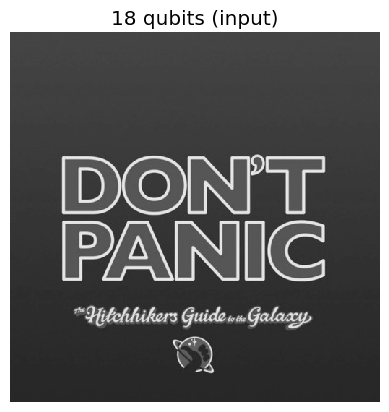

In [116]:
img = mpimg.imread('/content/drive/MyDrive/image_galaxy.jpg')

if len(img.shape) != 2:
    img = rgb2gray(img)

bitdepth = 8
black, white = 0, 2**bitdepth - 1

plt.rcParams.update({'font.size': 12})
Mr, Mc = img.shape
print('The resolution is', Mr, 'x', Mc, 'pixels.',\
      'There are', np.size(img), 'pixels.')

plt.imshow(img, cmap='gray', vmin = black, \
           vmax = white, interpolation = 'none')

plt.title('%i qubits (input)' %np.log2(Mr*Mc))
plt.axis('off')
plt.show()

In [117]:
Cr,Cc = Mr, Mc
states, norm = vectorization(img, Cr, Cc)
n0 = int(np.log2(Cr*Cc)) # Number of qubits for each circuit

print('The shape of the vectorized image is ', states.shape,\
      '. It will be loaded in ', states.shape[0],\
          ' circuit(s) of ' , n0, ' qubits.', sep='')

[[0.00195423 0.00195423 0.00195423 ... 0.0014513  0.0014513  0.0014703 ]]
The shape of the vectorized image is (1, 262144). It will be loaded in 1 circuit(s) of 18 qubits.


  0%|          | 0/8 [00:00<?, ?it/s]

[[0.00195423 0.00195423 0.00195423 ... 0.0014513  0.0014513  0.0014703 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=16777216) at 0x7ac0fa7284d0>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16]
Circuit 0 probs: [1.61528587e-05 1.43051147e-05 1.49011612e-05 ... 8.40425491e-06
 8.52346420e-06 7.62939453e-06]
[[1.61528587e-05 1.43051147e-05 1.49011612e-05 ... 8.40425491e-06
  8.52346420e-06 7.62939453e-06]]


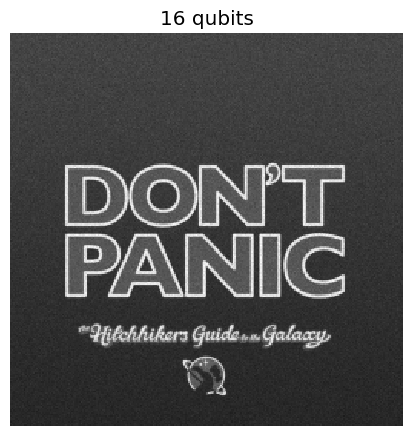

 12%|█▎        | 1/8 [00:19<02:18, 19.82s/it]

[[0.00195423 0.00195423 0.00195423 ... 0.0014513  0.0014513  0.0014703 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=4194304) at 0x7ac2fb83ca50>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [5.93662262e-05 5.81741333e-05 6.24656677e-05 ... 3.55243683e-05
 3.19480896e-05 3.76701355e-05]
[[5.93662262e-05 5.81741333e-05 6.24656677e-05 ... 3.55243683e-05
  3.19480896e-05 3.76701355e-05]]


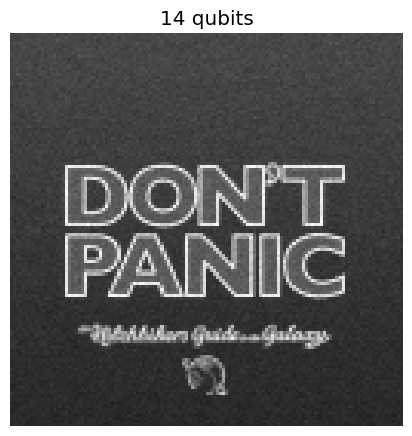

 25%|██▌       | 2/8 [00:22<00:57,  9.50s/it]

[[0.00195423 0.00195423 0.00195423 ... 0.0014513  0.0014513  0.0014703 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=1048576) at 0x7ac30859db50>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]
Circuit 0 probs: [0.00025082 0.00025845 0.00022411 ... 0.00014591 0.00013447 0.00013447]
[[0.00025082 0.00025845 0.00022411 ... 0.00014591 0.00013447 0.00013447]]


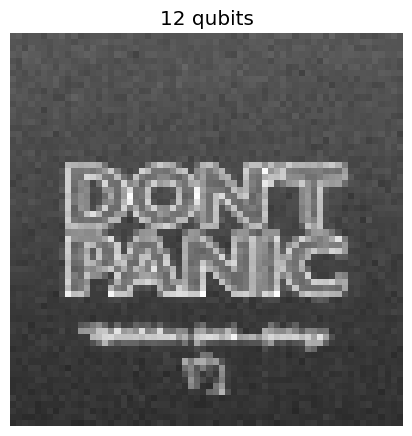

 38%|███▊      | 3/8 [00:22<00:27,  5.45s/it]

[[0.00195423 0.00195423 0.00195423 ... 0.0014513  0.0014513  0.0014703 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=262144) at 0x7ac3069e5b50>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 9, 10, 11, 12, 13]
Circuit 0 probs: [0.00097275 0.0010376  0.00096512 ... 0.00052643 0.00063705 0.00051117]
[[0.00097275 0.0010376  0.00096512 ... 0.00052643 0.00063705 0.00051117]]


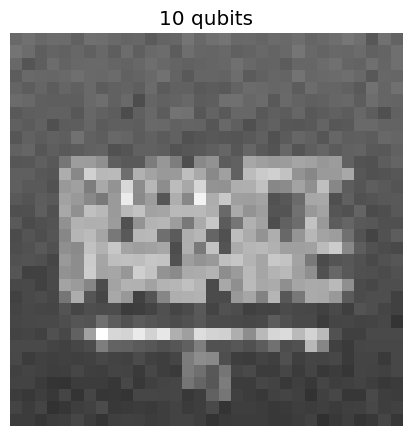

 50%|█████     | 4/8 [00:23<00:13,  3.43s/it]

[[0.00195423 0.00195423 0.00195423 ... 0.0014513  0.0014513  0.0014703 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=65536) at 0x7ac0fa723050>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 9, 10, 11, 12]
Circuit 0 probs: [0.00379944 0.0037384  0.0042572  0.00386047 0.00389099 0.00376892
 0.00360107 0.00416565 0.0037384  0.00416565 0.00389099 0.00393677
 0.00369263 0.00378418 0.00346375 0.00363159 0.00389099 0.00411987
 0.0038147  0.00386047 0.00402832 0.00366211 0.00392151 0.00325012
 0.00335693 0.00401306 0.00384521 0.00379944 0.00357056 0.00387573
 0.00366211 0.00401306 0.00357056 0.00408936 0.00386047 0.00370789
 0.00352478 0.00346375 0.00382996 0.00369263 0.00346375 0.00375366
 0.00367737 0.00360107 0.00405884 0.00367737 0.00419617 0.00346375
 0.00364685 0.00357056 0.00364685 0.00364685 0.003479   0.00334167
 0.00358582 0.00315857 0.00344849 0.00378418 0.00335693 0.00358582
 0.00370789 0.0037231

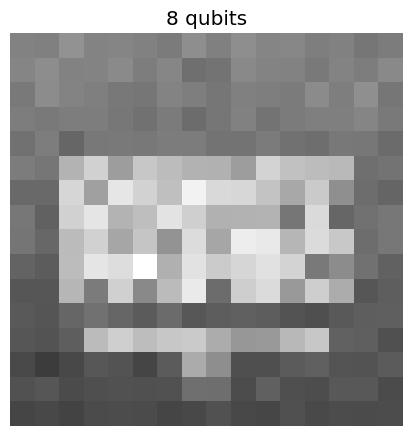

 62%|██████▎   | 5/8 [00:23<00:06,  2.30s/it]

[[0.00195423 0.00195423 0.00195423 ... 0.0014513  0.0014513  0.0014703 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=16384) at 0x7ac0fa712a90>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 9, 10, 11]
Circuit 0 probs: [0.01678467 0.015625   0.01428223 0.01318359 0.0133667  0.01470947
 0.01629639 0.0145874  0.01452637 0.01367188 0.01647949 0.01403809
 0.01403809 0.01422119 0.01586914 0.01434326 0.01245117 0.01849365
 0.01715088 0.01733398 0.01593018 0.01837158 0.01715088 0.01531982
 0.01361084 0.02325439 0.0223999  0.02679443 0.02264404 0.01727295
 0.019104   0.01367188 0.01287842 0.02398682 0.02496338 0.02166748
 0.02258301 0.02392578 0.0201416  0.01086426 0.00976562 0.01483154
 0.01660156 0.01831055 0.01531982 0.01623535 0.01629639 0.0112915
 0.01092529 0.01330566 0.01617432 0.01708984 0.01556396 0.01544189
 0.01434326 0.01116943 0.00982666 0.00891113 0.01123047 0.01068115
 0.01037598 0.00897217 0.0111

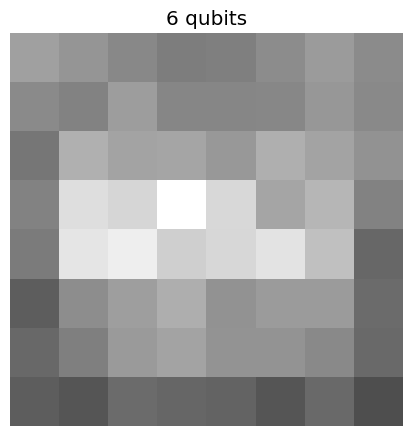

 75%|███████▌  | 6/8 [00:23<00:03,  1.60s/it]

[[0.00195423 0.00195423 0.00195423 ... 0.0014513  0.0014513  0.0014703 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=4096) at 0x7ac3070dab50>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999927
Measured qubits: [0, 1, 9, 10]
Circuit 0 probs: [0.06469727 0.05810547 0.05957031 0.06103516 0.06811523 0.07446289
 0.07983398 0.07080078 0.06030273 0.08056641 0.07861328 0.05981445
 0.0390625  0.05444336 0.0534668  0.03710938]
[[0.06469727 0.05810547 0.05957031 0.06103516 0.06811523 0.07446289
  0.07983398 0.07080078 0.06030273 0.08056641 0.07861328 0.05981445
  0.0390625  0.05444336 0.0534668  0.03710938]]


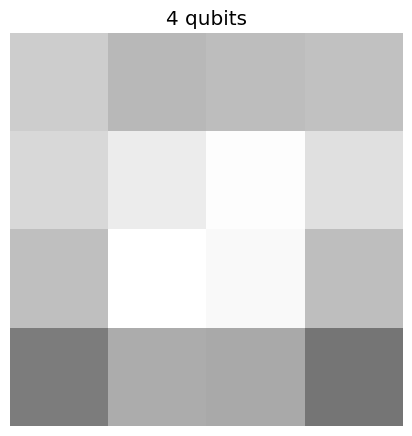

 88%|████████▊ | 7/8 [00:23<00:01,  1.16s/it]

[[0.00195423 0.00195423 0.00195423 ... 0.0014513  0.0014513  0.0014703 ]]
[<QNode: device='<lightning.qubit device (wires=18, shots=1024) at 0x7ac2fba6ae50>', interface='auto', diff_method='best'>]
QCS are built: 1
State norm: 0.9999999999999927
Measured qubits: [0, 9]
Circuit 0 probs: [0.26171875 0.27539062 0.234375   0.22851562]
[[0.26171875 0.27539062 0.234375   0.22851562]]


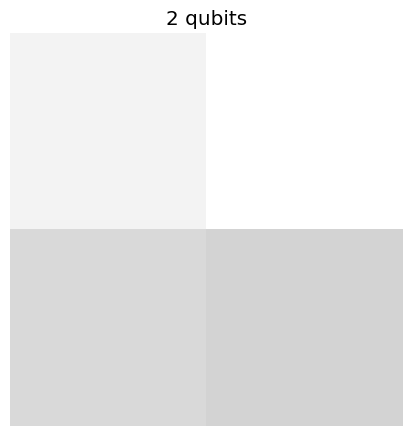

100%|██████████| 8/8 [00:24<00:00,  3.01s/it]


In [118]:
for n2 in tqdm(range(n0-2, 0, -2)):
    shots = 2**(n2+bitdepth)

    states, norm = vectorization(img, Cr, Cc)
    qcs = circuit_builder(states, n0, n2, shots)
    print(qcs)
    print(f'QCS are built: {len(qcs)}')
    out_freq = reconstruction(qcs, n2, norm)
    print(out_freq)
    final_img = devectorization(out_freq)*shots

    black, white = 0, 2**bitdepth - 1
    final_img = final_img/final_img.max()*white

    plt.imshow(final_img, cmap='gray', vmin = black, vmax = white,\
               interpolation = 'none')

    plt.title('%i qubits' %n2)
    plt.tight_layout()
    plt.axis('off')

    # Save
    filename = 'output/images/output' + str(n2) + 'q' + '.png'

    plt.show()
    plt.close()

In [119]:
trials = 20
n2 = 14

final_images = np.zeros((trials,2**(n2)))
states, norm = vectorization(img, Cr, Cc)
qcs = circuit_builder(states, n0, n2, shots)

[[0.00195423 0.00195423 0.00195423 ... 0.0014513  0.0014513  0.0014703 ]]


In [120]:
print('Standard deviation estimation: ')

for idx in tqdm(range(trials)):
    shots = 2**(n2)
    out_freq = reconstruction(qcs, n2, norm)
    final_img = devectorization(out_freq)*shots

    black, white = 0, 255
    final_img = final_img/final_img.max()*white

    final_images[idx,:] = np.reshape(final_img, 2**n2)

stds = np.std(final_images, axis=0)

Standard deviation estimation: 


  0%|          | 0/20 [00:00<?, ?it/s]

State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]


 10%|█         | 2/20 [00:00<00:04,  4.02it/s]

Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0.         0.         0.         ... 0.         0.         0.00097656]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]


 20%|██        | 4/20 [00:00<00:03,  5.22it/s]

Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]


 30%|███       | 6/20 [00:01<00:02,  5.52it/s]

Circuit 0 probs: [0.         0.00097656 0.         ... 0.         0.         0.        ]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]


 35%|███▌      | 7/20 [00:01<00:02,  5.06it/s]

Circuit 0 probs: [0.         0.         0.         ... 0.         0.00097656 0.        ]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]


 45%|████▌     | 9/20 [00:01<00:02,  4.98it/s]

Circuit 0 probs: [0.         0.00097656 0.         ... 0.         0.         0.        ]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]


 50%|█████     | 10/20 [00:02<00:01,  5.09it/s]

Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]


 60%|██████    | 12/20 [00:02<00:01,  4.62it/s]

Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]


 70%|███████   | 14/20 [00:02<00:01,  5.19it/s]

Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]


 75%|███████▌  | 15/20 [00:03<00:01,  4.41it/s]

Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]


 80%|████████  | 16/20 [00:03<00:00,  4.04it/s]

Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]


 85%|████████▌ | 17/20 [00:03<00:00,  3.95it/s]

Circuit 0 probs: [0.         0.         0.         ... 0.         0.         0.00097656]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]


 90%|█████████ | 18/20 [00:04<00:00,  3.75it/s]

Circuit 0 probs: [0.         0.         0.         ... 0.00097656 0.         0.        ]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]


 95%|█████████▌| 19/20 [00:04<00:00,  3.92it/s]

Circuit 0 probs: [0.         0.         0.         ... 0.         0.00195312 0.        ]
State norm: 0.9999999999999927
Measured qubits: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]


100%|██████████| 20/20 [00:04<00:00,  4.33it/s]

Circuit 0 probs: [0. 0. 0. ... 0. 0. 0.]


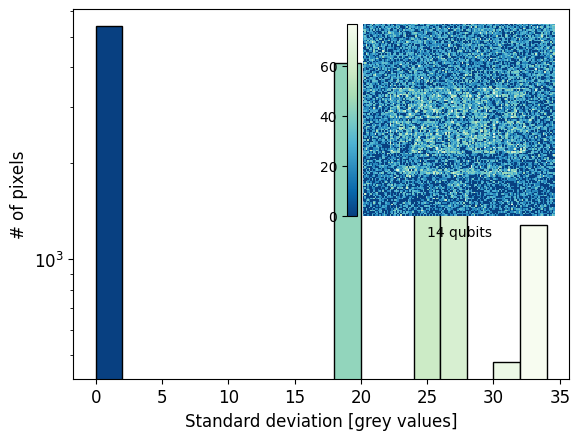

In [121]:
fig, ax1 = plt.subplots()
cmap = plt.cm.GnBu_r

bins = np.arange(0,35,2)
h_n, h_bins, h_patches = ax1.hist(stds, bins = bins, edgecolor='black', linewidth = 1)
plt.yscale('log',base=10)

bin_centers = 0.5 * (h_bins[:-1] + h_bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, h_patches):
    plt.setp(p, 'facecolor', cmap(c))

ax1.set_xlabel('Standard deviation [grey values]')
ax1.set_ylabel('# of pixels')

left, bottom, width, height = [0.508, 0.45, 0.4, 0.40]
ax2 = fig.add_axes([left, bottom, width, height])

stds_mtx = np.reshape(stds, (2**(n2//2), 2**(n2//2)))
cax = ax2.matshow(stds_mtx, cmap=cmap, interpolation = 'none')
ax2.axis('off')
ax2.set_title(str(n2) + ' qubits', fontsize=10, y=-0.15)
cbar = fig.colorbar(cax, location='left', pad= 0.025)
cbar.ax.tick_params(labelsize=10)

plt.show()